In [1]:
import numpy as np
import random
import os

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def norm_x(x):
    for col in range(x.shape[1]):
        vals = x[:,col]
        vals = (vals-np.mean(vals))/np.std(vals)
        x[:,col] = vals
    return x

In [4]:
def sampleChania(Chania, n_points):
    data = Chania[:,0:8]
    order = np.argsort(np.random.random(data.shape[0]))
    x = data[order][:n_points, 1:5]   
    trueusers = data[order][:n_points,0]
    n_clusters = 5
    x = norm_x(x)
    return tf.constant(x, dtype=tf.float32), tf.constant(trueusers, dtype=tf.float32)

In [5]:
def plot_rssi(x, y, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].scatter(xarray[:,3], xarray[:,2], c=xarray[:,1])
    ax[0].set_title("True Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(xarray[:,1]), np.max(xarray[:,1])))
    
    ax[1].scatter(yarray[:,3], yarray[:,2], c=yarray[:,1])
    ax[1].set_title("Obfuscated Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(yarray[:,1]), np.max(yarray[:,1])))

In [6]:
def plot_users(x, y, z, trueusers, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    zarray = z.eval(session=sess)
    u = trueusers.eval(session=sess)
    
    fig, ax1 = plt.subplots(1, 2, figsize=(15,5))
    
    ax1[0].scatter(xarray[:,3], xarray[:,2], c=u)
    ax1[0].set_title("User Labels")
    
    ax1[1].scatter(yarray[:,3], yarray[:,2], c=u)
    ax1[1].set_title("Obfuscated data - User Labels")
    
    fig, ax2 = plt.subplots(1, 2, figsize=(15,5))
    
    ax2[0].scatter(xarray[:,3], xarray[:,2], c=np.argmax(zarray, axis=1))
    ax2[0].set_title("User Labels estimated by adversary")
    
    ax2[1].scatter(yarray[:,3], yarray[:,2], c=np.argmax(zarray, axis=1))
    ax2[1].set_title("Obfuscated data - User Labels estimated by adversary")

In [73]:
def plot_maps(sess):   
    testpoints = np.mgrid[-1.5:1.5:15j, -1.5:1.5:15j].reshape(2,-1).T
    grid = tf.constant(testpoints, dtype=tf.float32)

    inputmap = i4(i3(i2(i1(grid)))).eval(session=sess)
    outputmap = o4(o3(o2(o1(grid)))).eval(session=sess)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].scatter(testpoints[:,1], testpoints[:,0], c=inputmap[:,0])
    ax[0].set_title("Map created from True Data, min=%.4f, max=%.4f"%(np.min(inputmap[:,0]), np.max(inputmap[:,0])))
    ax[1].scatter(testpoints[:,1], testpoints[:,0], c=outputmap[:,0])
    ax[1].set_title("Map created from Obfuscated Data, min=%.4f, max=%.4f"%(np.min(outputmap[:,0]), np.max(outputmap[:,0])))

In [8]:
Chania = np.genfromtxt('processedChania.csv', delimiter=',')

In [9]:
Chania = Chania[np.where(Chania[:,2]<99)]

Restart here

In [149]:
sess = tf.Session()
keras.backend.set_session(sess)

In [150]:
x, trueusers = sampleChania(Chania, 100)

In [151]:
p1 = keras.layers.Dense(4, activation=tf.nn.relu)
p2 = keras.layers.Dense(4, activation=tf.nn.relu)
p3 = keras.layers.Dense(4, activation=tf.nn.relu)
p4 = keras.layers.Dense(4, activation=tf.nn.relu)
p5 = keras.layers.Dense(4)

y = p5(p4(p3(p2(p1(x)))))
p_vars = [p1.variables, p2.variables, p3.variables, p4.variables, p5.variables]

In [152]:
i1 = keras.layers.Dense(4, activation=tf.nn.relu)
i2 = keras.layers.Dense(4, activation=tf.nn.relu)
i3 = keras.layers.Dense(4, activation=tf.nn.relu)
i4 = keras.layers.Dense(1)

m1 = i4(i3(i2(i1(x[:,2:]))))
m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
m1_train = tf.train.GradientDescentOptimizer(0.1)
m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]

In [153]:
o1 = keras.layers.Dense(4, activation=tf.nn.relu)
o2 = keras.layers.Dense(4, activation=tf.nn.relu)
o3 = keras.layers.Dense(4, activation=tf.nn.relu)
o4 = keras.layers.Dense(1)

m2 = o4(o3(o2(o1(y[:,2:]))))
m2_target = tf.keras.backend.reshape(y[:,1], (100,1))
m2_train = tf.train.GradientDescentOptimizer(0.1)
m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

In [154]:
a1 = keras.layers.Dense(7, activation=tf.nn.relu)
a2 = keras.layers.Dense(5, activation=tf.nn.softmax)

users = a2(a1(y))
a_train = tf.train.GradientDescentOptimizer(0.08)
a_vars = [a1.variables, a2.variables]

In [155]:
combined = a2(a1(p5(p4(p3(p2(p1(x)))))))
p_train = tf.train.GradientDescentOptimizer(0.01)

In [156]:
m1_loss = tf.placeholder(tf.float32)
m2_loss = tf.placeholder(tf.float32)
map_error = tf.placeholder(tf.float32)
adversary_loss = tf.placeholder(tf.float32)
privatizer_loss = tf.placeholder(tf.float32)
penalty = tf.placeholder(tf.float32)

In [157]:
sess.run(tf.global_variables_initializer())

In [158]:
# train m1
m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

In [159]:
# train m2
m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m2, m2_target))
m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)

In [160]:
adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
a_train = a_train.minimize(adversary_loss, var_list = a_vars)

In [161]:
map_error = tf.reduce_mean(tf.squared_difference(
    i4(i3(i2(i1(p5(p4(p3(p2(p1(x)))))[:,2:])))), 
    o4(o3(o2(o1(p5(p4(p3(p2(p1(x)))))[:,2:]))))
))

In [162]:
penalty = tf.constant(10, dtype=tf.float32)

In [163]:
privatizer_loss = tf.subtract(tf.multiply(map_error, penalty), 
                              tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, combined)))
p_train = p_train.minimize(privatizer_loss, var_list = p_vars)

In [164]:
def train(trainstep, trainloss, max_iter):
    plotlist = []
    delta1 = 100
    delta2 = 0
    count_iter = 0
    while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
        count_iter += 1
        delta1 = trainloss.eval(session=sess)
        trainstep.run(session=sess)
        delta2 = trainloss.eval(session=sess)
        plotlist.append(trainloss.eval(session=sess))
    print("after", count_iter, "iterations...")
    print("final loss", plotlist[-1])
    return plotlist

input map
after 45 iterations...
final loss 0.78344214
output map
after 1 iterations...
final loss 2.6341255e-05
adversary
after 1034 iterations...
final loss 0.65091485
privatizer
after 93 iterations...
final loss -11.282185

Privatizer improvement: 9.689985


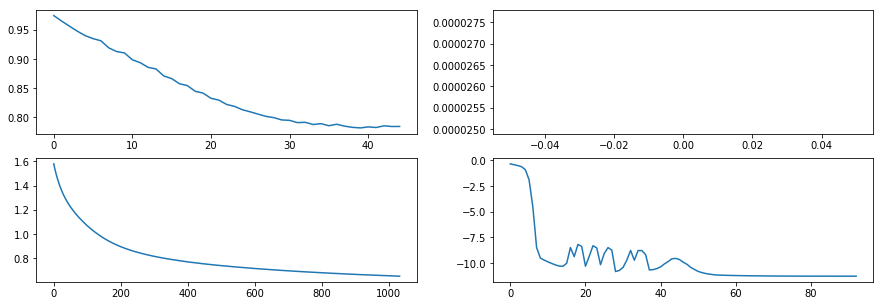

In [165]:
# x, trueusers = sampleChania(Chania, 100)
# y = p5(p4(p3(p2(p1(x)))))
# m1 = i4(i3(i2(i1(x[:,2:]))))
# m2 = o4(o3(o2(o1(y[:,2:]))))
# users = a2(a1(y))
# combined = a2(a1(p5(p4(p3(p2(p1(x)))))))

delta1 = privatizer_loss.eval(session=sess)
print("input map")
m1plot = train(m1_train, m1_loss, 1000)
print("output map")
m2plot = train(m2_train, m2_loss, 1000)
print("adversary")
aplot = train(a_train, adversary_loss, 2000)
print("privatizer")
pplot = train(p_train, privatizer_loss, 1000)
delta2 = privatizer_loss.eval(session=sess)
print("")
print("Privatizer improvement:", delta1-delta2)

fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0][0].plot(m1plot)
ax[0][1].plot(m2plot)
ax[1][0].plot(aplot)
ax[1][1].plot(pplot)

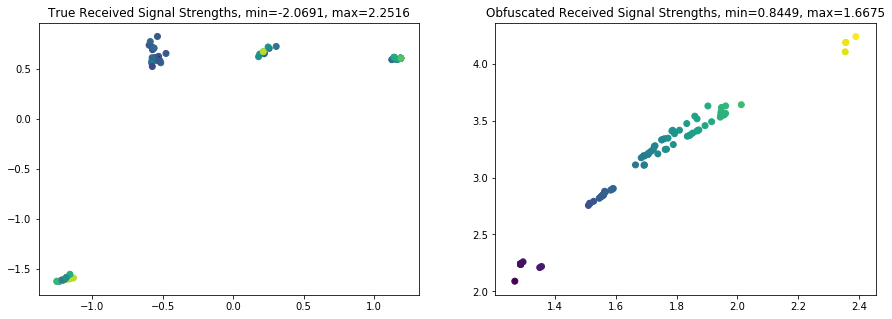

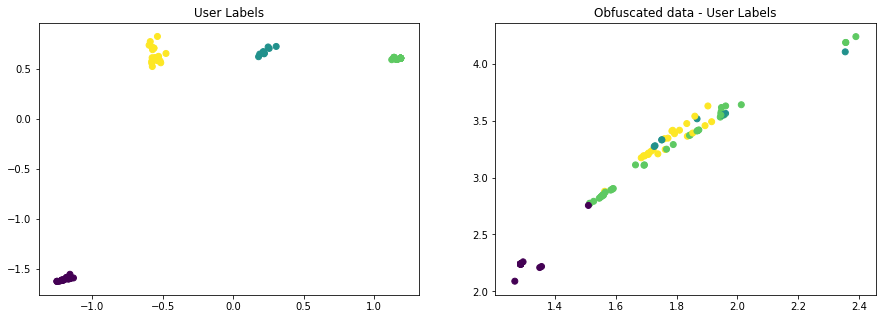

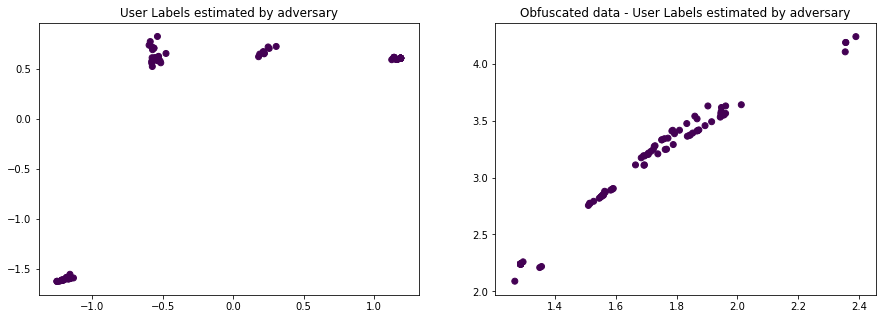

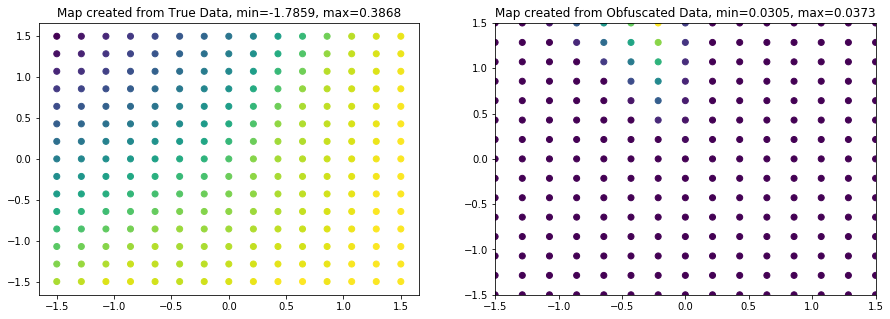

In [72]:
plot_rssi(x, y, sess)
plot_users(x, y, users, trueusers, sess)
plot_maps(sess)

### Adversary in isolation

one relu layer with 7 units, one softmax layer with 5 outputs  
learning rate 0.08, stop early at delta = 0.0001

In [50]:
np.random.seed(0)

sess = tf.Session()
keras.backend.set_session(sess)
x, trueusers = sampleChania(Chania, 100)

a1 = keras.layers.Dense(7, activation=tf.nn.relu)
a5 = keras.layers.Dense(5, activation=tf.nn.softmax)

users = a5(a1(x))
a_vars = [a1.variables, a5.variables]


a_train = tf.train.GradientDescentOptimizer(0.08)
sess.run(tf.global_variables_initializer())

adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
a_train = a_train.minimize(adversary_loss, var_list = a_vars)

after 826 iterations...
final loss 0.04096859


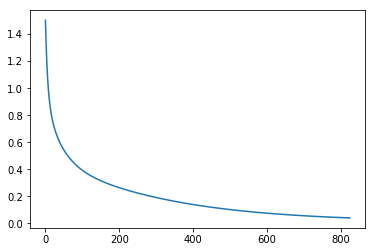

In [51]:
train(a_train, adversary_loss, 1000, True)

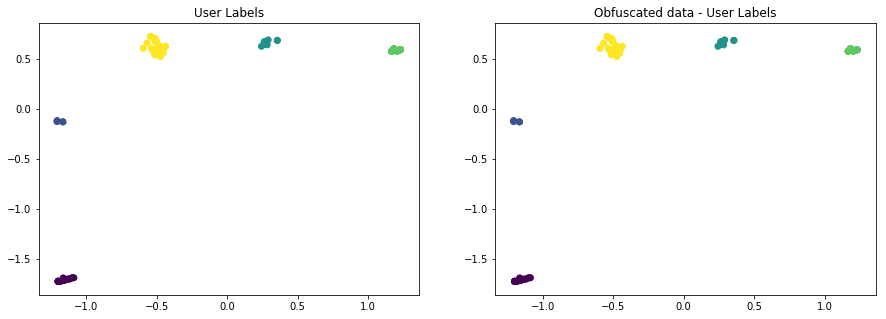

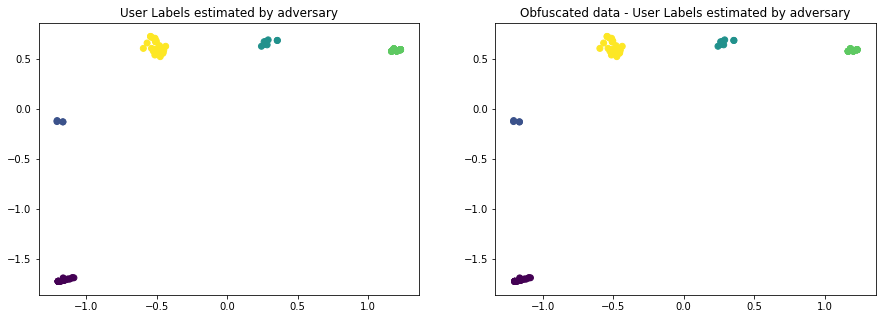

In [52]:
plot_users(x, x, users, trueusers, sess)

### Map in isolation

In [44]:
np.random.seed(0)

sess = tf.Session()
keras.backend.set_session(sess)

x, trueusers = sampleChania(Chania, 80)

i1 = keras.layers.Dense(4, activation=tf.nn.relu)
i2 = keras.layers.Dense(4, activation=tf.nn.relu)
i3 = keras.layers.Dense(4, activation=tf.nn.relu)
# i4 = keras.layers.Dense(16, activation=tf.nn.relu)
# i5 = keras.layers.Dense(16, activation=tf.nn.relu)
# i6 = keras.layers.Dense(16, activation=tf.nn.relu)
# i7 = keras.layers.Dense(16, activation=tf.nn.relu)
i8 = keras.layers.Dense(1)

# m1 = i8(i7(i6(i5(i4(i3(i2(i1(x[:,2:]))))))))
m1 = i8(i3(i2(i1(x[:,2:]))))
# m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables, 
#            i5.variables, i6.variables, i7.variables, i8.variables]
m1_vars = [i1.variables, i2.variables, i3.variables, i8.variables]

m1_target = tf.keras.backend.reshape(x[:,1], (80,1))
m1_train = tf.train.GradientDescentOptimizer(0.1)
m1_loss = tf.placeholder(tf.float32)

sess.run(tf.global_variables_initializer())

m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

after 41 iterations...
final loss 0.6482523


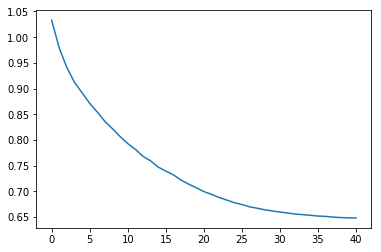

In [45]:
train(m1_train, m1_loss, 100, True)

Text(0.5, 1.0, 'True Received Signal Strengths, min=-3.0709, max=2.5768')

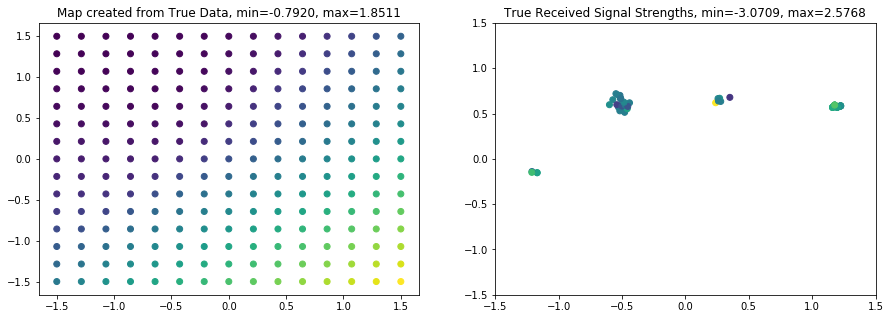

In [46]:
testpoints = np.mgrid[-1.5:1.5:15j, -1.5:1.5:15j].reshape(2,-1).T
grid = tf.constant(testpoints, dtype=tf.float32)

inputmap = i8(i3(i2(i1(grid)))).eval(session=sess)
xarray = x.eval(session=sess)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(testpoints[:,1], testpoints[:,0], c=inputmap[:,0])
ax[0].set_title("Map created from True Data, min=%.4f, max=%.4f"%(np.min(inputmap[:,0]), np.max(inputmap[:,0])))
    
ax[1].scatter(xarray[:,3], xarray[:,2], c=xarray[:,1])
ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-1.5,1.5])
ax[1].set_title("True Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(xarray[:,1]), np.max(xarray[:,1])))